In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pylab import rcParams
from fbprophet import Prophet
import dateparser
import pmdarima as pm

from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

Importing plotly failed. Interactive plots will not work.


In [2]:
train = pd.read_csv("Train.csv")
train['Datetime'] = pd.to_datetime(train['Datetime'], format = '%d-%m-%Y %H:%M')
train['Date'] = train["Datetime"].dt.date
train = train.groupby(['Date'])['Count'].sum().reset_index()
train = train.set_index('Date')
train.head(5)

,Count
Date,
2012-08-25,76
2012-08-26,88
2012-08-27,62
2012-08-28,58
2012-08-29,60


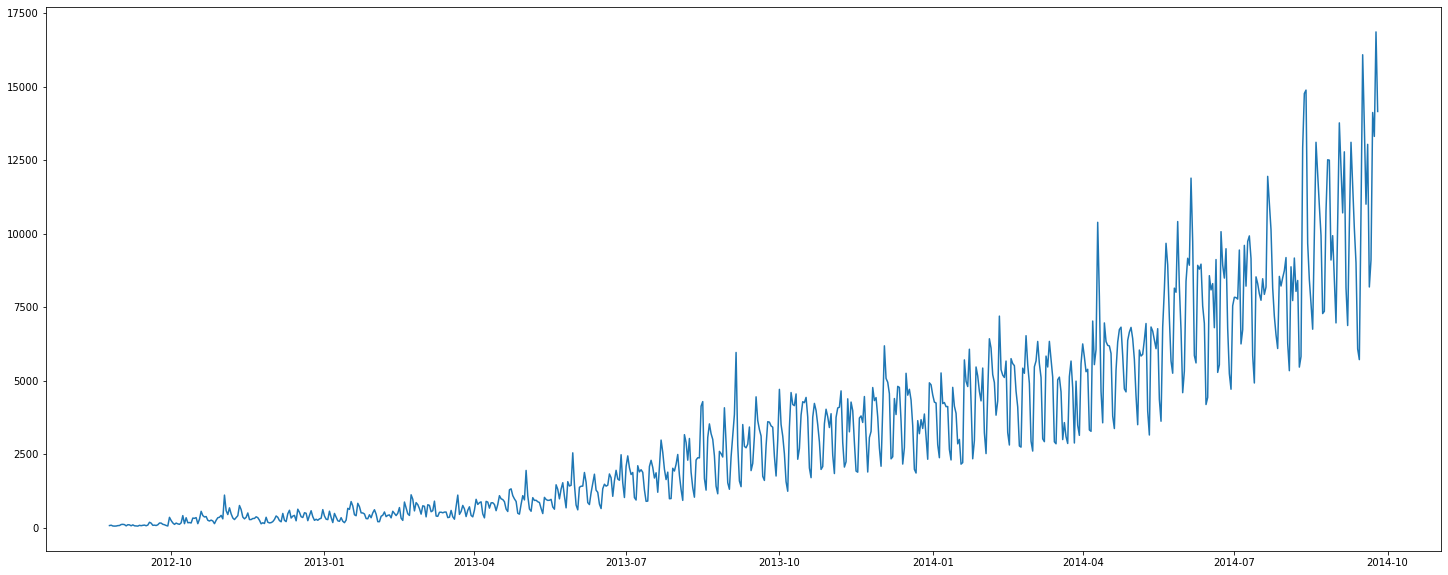

In [3]:
plt.figure(figsize=(25,10))
plt.plot(train.index, train.Count)

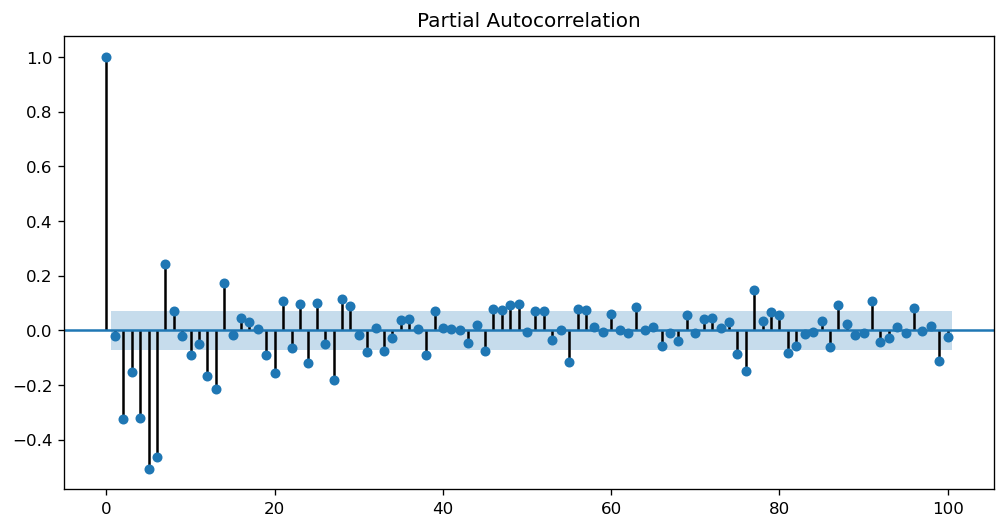

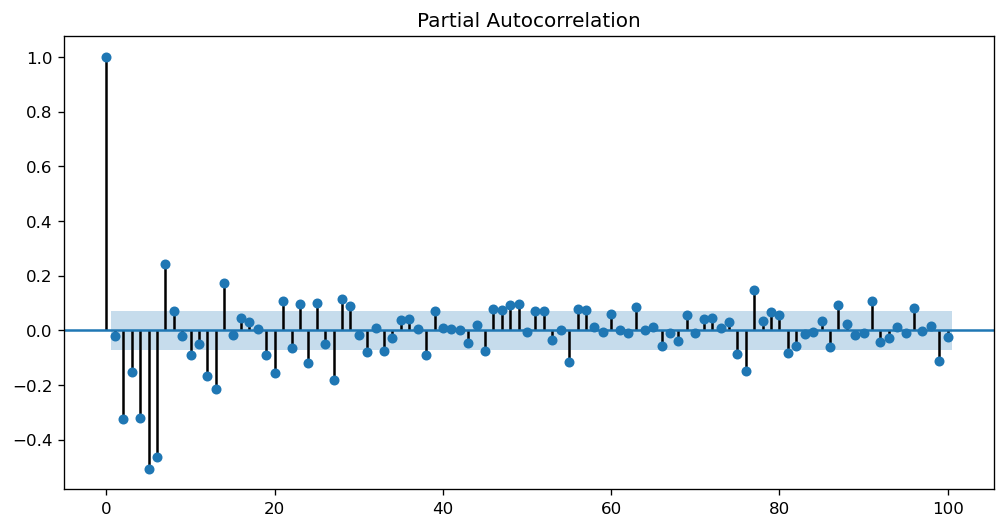

In [4]:
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})
plot_pacf(train.Count.diff().dropna(), lags=100)

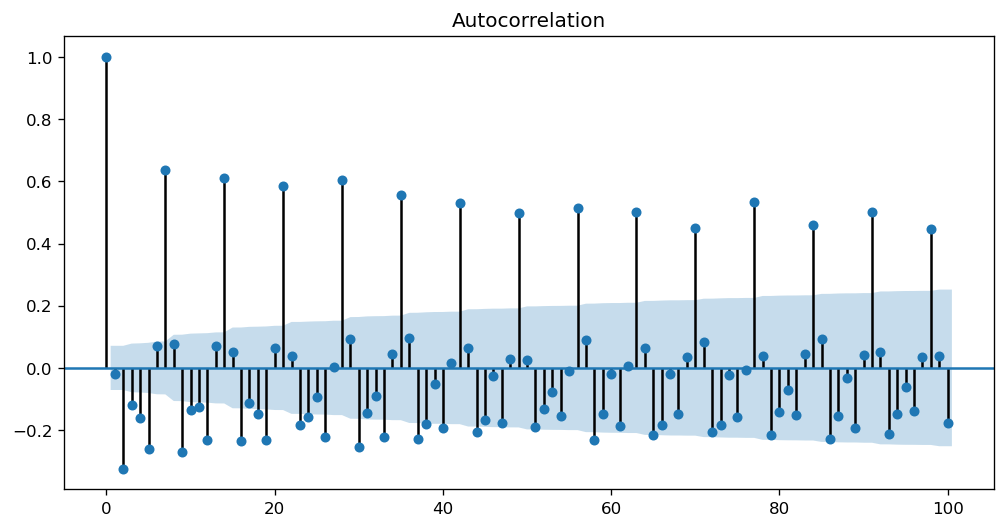

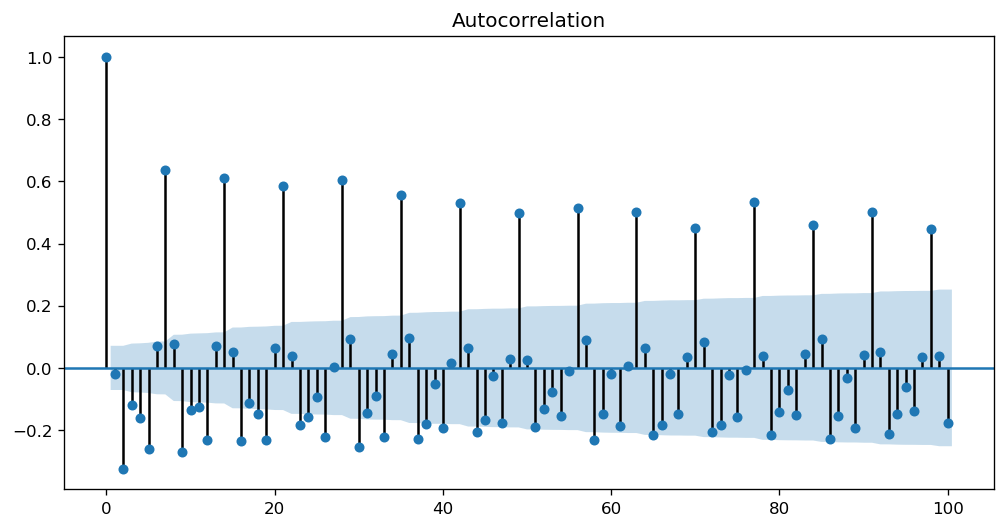

In [5]:
plt.rcParams.update({'figure.figsize':(10,5), 'figure.dpi':120})
plot_acf(train.Count.diff().dropna(), lags=100)

<ipython-input-6-64532a722fe9>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  sm.tsa.seasonal_decompose(train.Count, freq=24).plot()


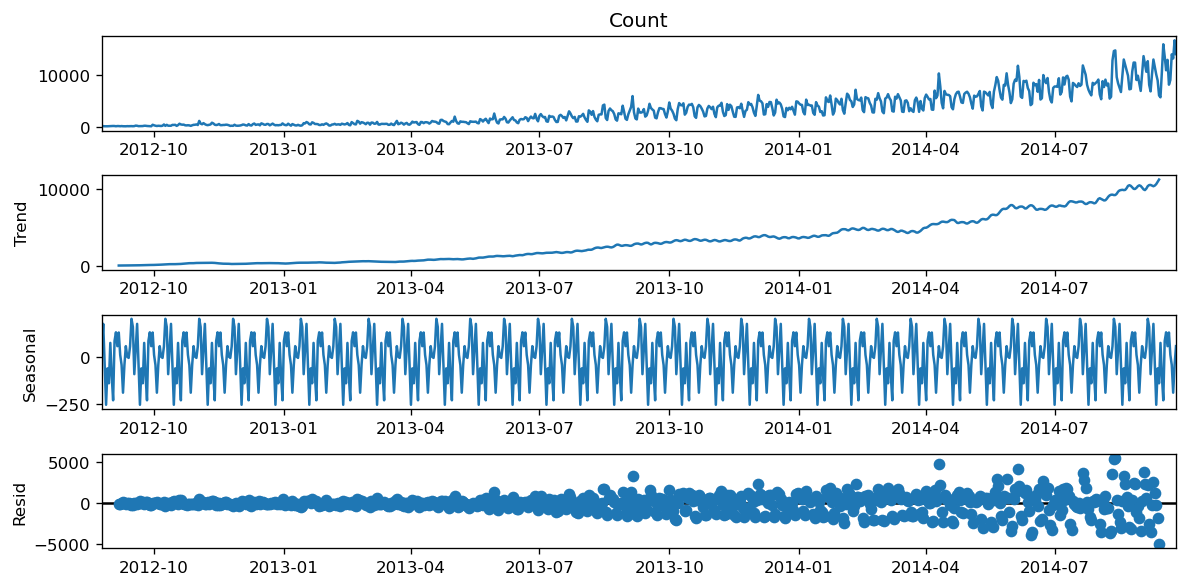

In [6]:
sm.tsa.seasonal_decompose(train.Count, freq=24).plot()
result = sm.tsa.stattools.adfuller(train.Count)
plt.show()

In [7]:
X = train.values
train_df = X[0:535]
test_df = X[535:]
predictions = []

import itertools
from tqdm.notebook import tqdm
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

param_aic_seasonal = {}
for param in tqdm(pdq):
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statspace.SARIMAX(train,
                                          order = param,
                                          seasonal_order = param_seasonal)
            
            results = mod.fit()
            param_aic_seasonal[param, param_seasonal] =results.aic
        
        except:
            continue

In [8]:
{k: v for k, v in sorted(param_aic_seasonal.items(), key = lambda item:item[1])}

{}

In [9]:
mod = sm.tsa.statespace.SARIMAX(train_df, order = (0, 1, 2), seasonal_order = (0, 2, 2, 7))
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  535
Model:             SARIMAX(0, 1, 2)x(0, 2, 2, 7)   Log Likelihood               -3893.465
Date:                           Tue, 24 Nov 2020   AIC                           7796.931
Time:                                   01:05:02   BIC                           7818.200
Sample:                                        0   HQIC                          7805.263
                                           - 535                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5797      0.029    -19.663      0.000      -0.637      -0.522
ma.L2         -0.2894      0.033     -8.767

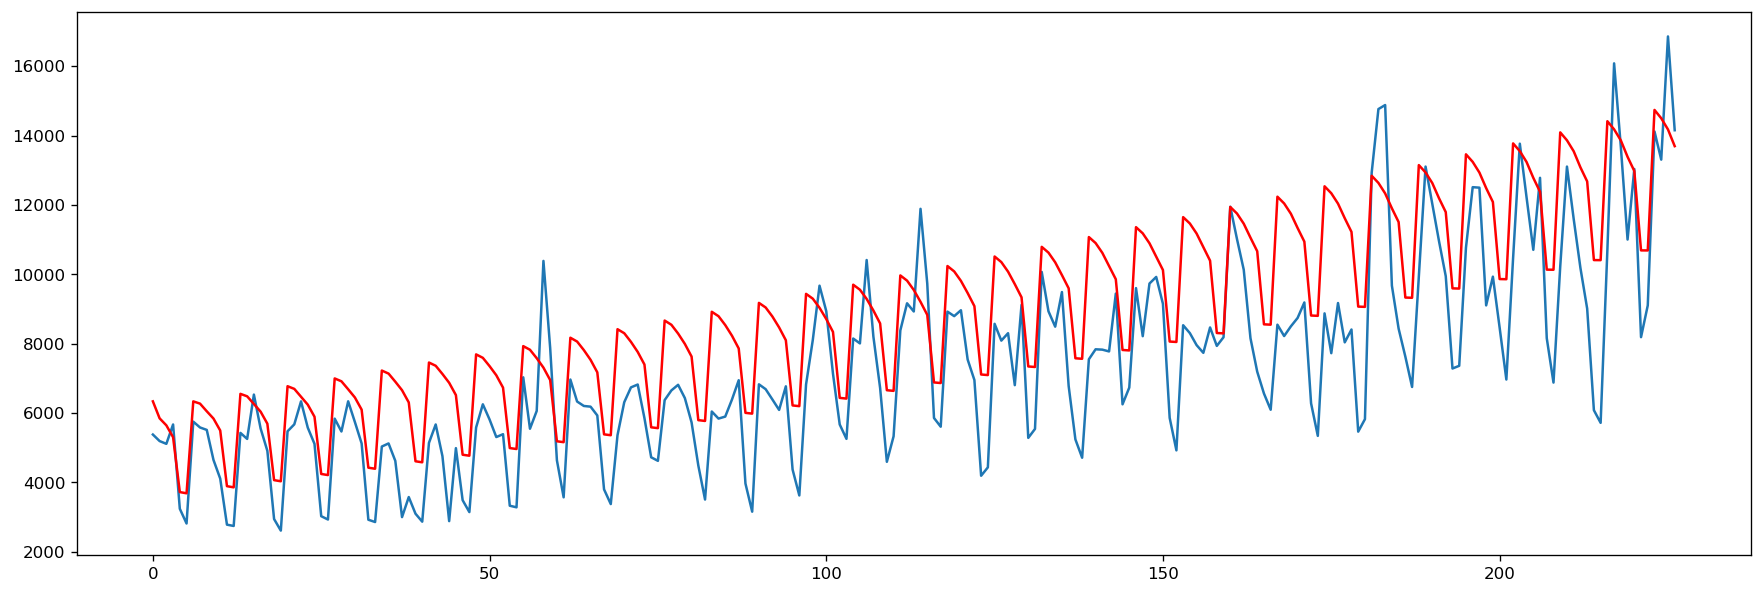

2013332.9299111024


In [10]:
y_pred = results.predict(start = 535, end = 761, dynamic = True)
rcParams['figure.figsize'] = 18, 6
plt.plot(test_df)
plt.plot(y_pred, color ='red')
plt.show()
print(y_pred.sum())

In [11]:
train_data = train[:]

mod = sm.tsa.statespace.SARIMAX(train_data['Count'], order=(0, 1, 2), seasonal_order=(0, 2, 2, 7))
results = mod.fit()
print(results.summary())

y_new = results.predict(start = 762, end = 974, dynamic = True)
y_old = results.predict(start = 0, end = 761, dynamic = True )
print(y_new.sum())

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                                     SARIMAX Results                                     
Dep. Variable:                             Count   No. Observations:                  762
Model:             SARIMAX(0, 1, 2)x(0, 2, 2, 7)   Log Likelihood               -5976.453
Date:                           Tue, 24 Nov 2020   AIC                          11962.905
Time:                                   01:05:08   BIC                          11985.986
Sample:                               08-25-2012   HQIC                         11971.800
                                    - 09-25-2014                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4725      0.024    -19.799      0.000      -0.519      -0.426
ma.L2         -0.4178      0.022    -19.322

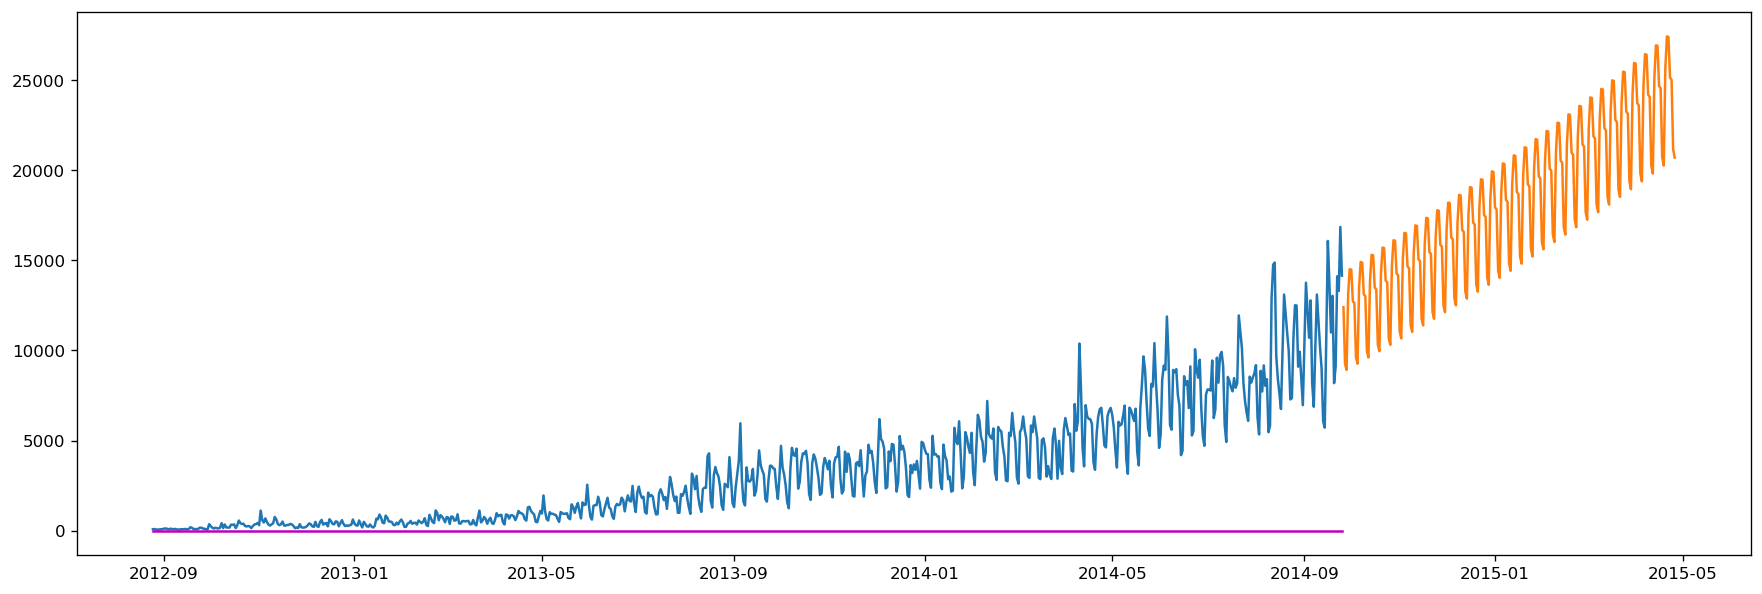

In [12]:
plt.plot(train.index, train['Count'])
plt.plot(y_new.index, y_new)
plt.plot(y_old.index, y_old, 'm')
plt.show()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.


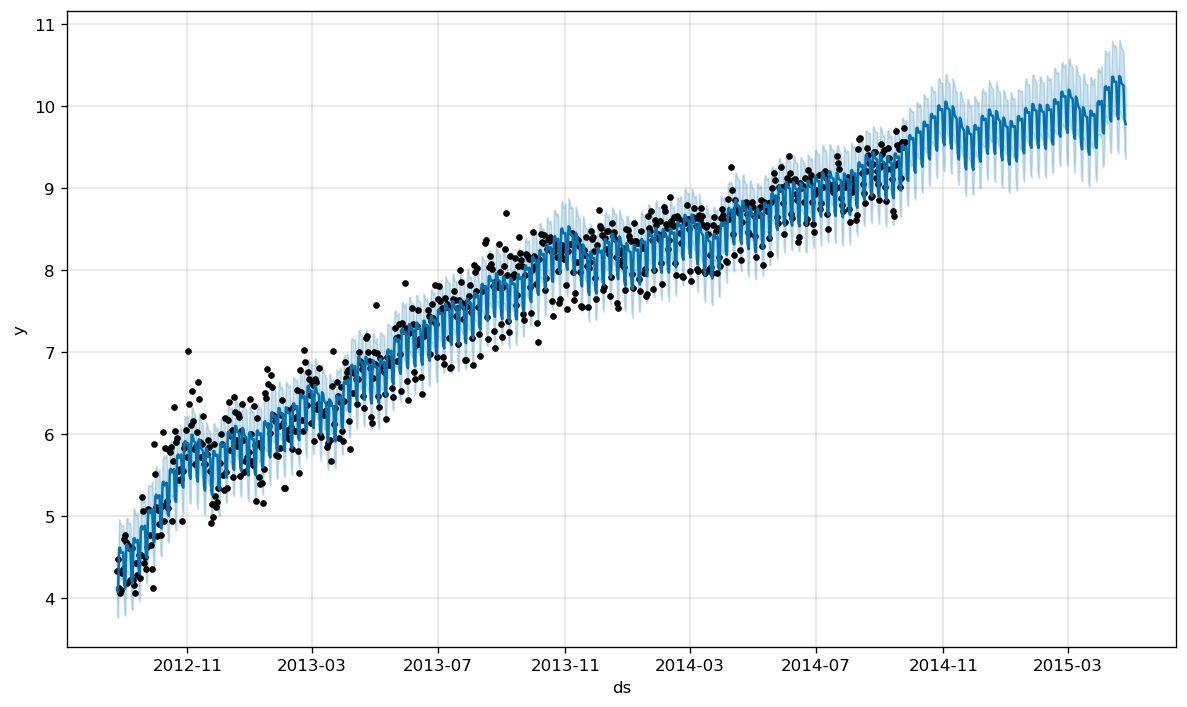

In [13]:
train = pd.read_csv('Train.csv')
train['Datetime'] = pd.to_datetime(train['Datetime'], format = '%d-%m-%Y %H:%M')
train['Date'] = train["Datetime"].dt.date
train = train.groupby(['Date'])['Count'].sum().reset_index()
train.columns = ['ds', 'y']
train['y'] = np.log(train['y'])
model = Prophet(daily_seasonality=False)
model.add_seasonality(name='weekly', period =7, fourier_order=300)
model.fit(train)
future = model.make_future_dataframe(periods=213)
forecast = model.predict(future)
fig1 = model.plot(forecast)

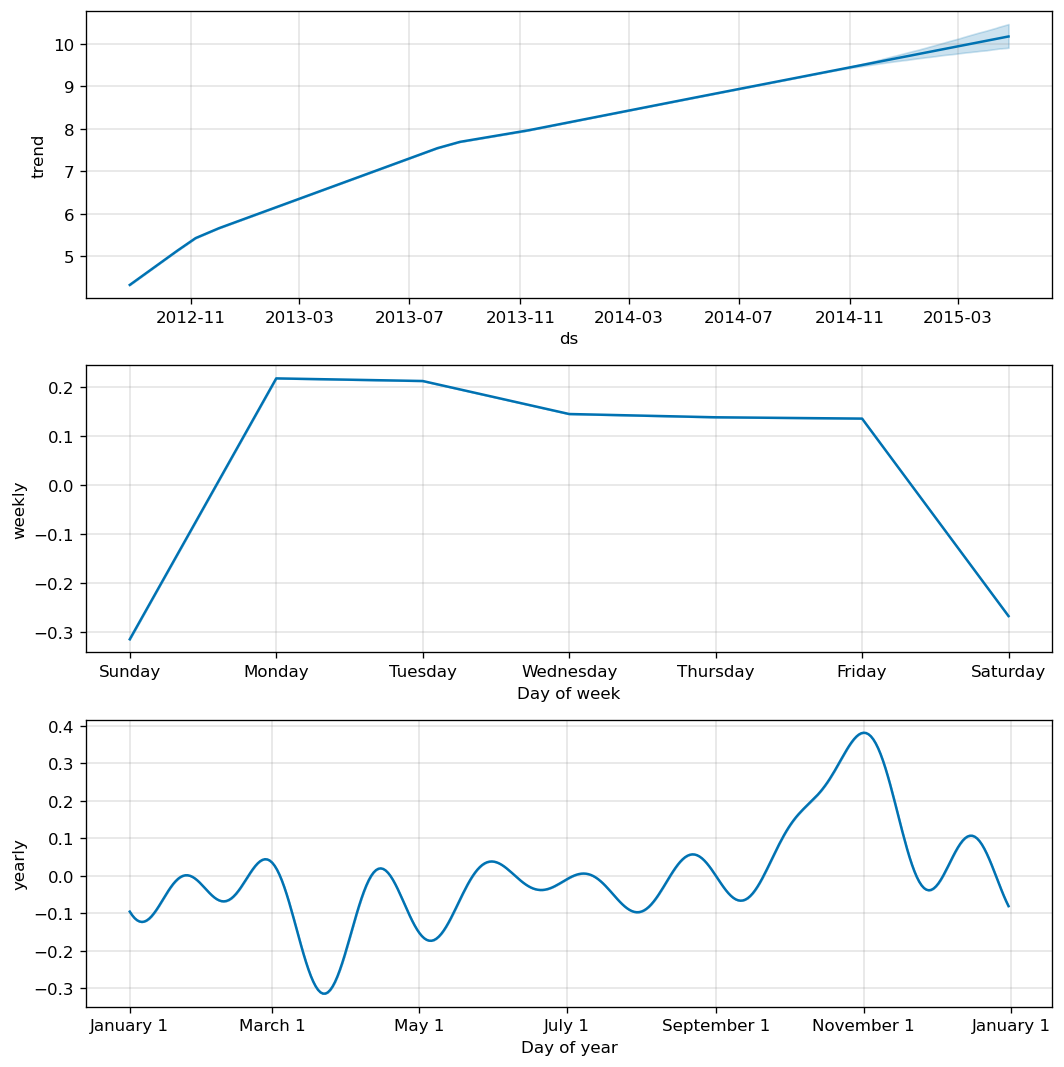

In [14]:
fig2 = model.plot_components(forecast)

In [15]:
f_preds = np.exp(forecast[-213:]['yhat']).values
er = []
listm = [0.044286588, 0.035343014, 0.029911076, 0.024714453, 0.02080223, 0.018621427, 
         0.020023091, 0.023221497, 0.026741002, 0.034555218, 0.049047207, 0.05437526, 
         0.054951351, 0.048600186, 0.051965438, 0.051309072, 0.049999488, 0.051164262, 
         0.052423477, 0.055626605, 0.053455246, 0.049894816, 0.050075828, 0.048892166]

for p in range(len(f_preds)):
    for l in range(len(listm)):
        er.append(f_preds[p]*listm[l])

result = {'Count':er}
submission_df = pd.DataFrame({
                    'ID': pd.Series([x+18288 for x in range(5112)]),
                    'Count': pd.Series(result['Count'])})
submission_df.to_csv('submission_test_fb.csv', index=False)

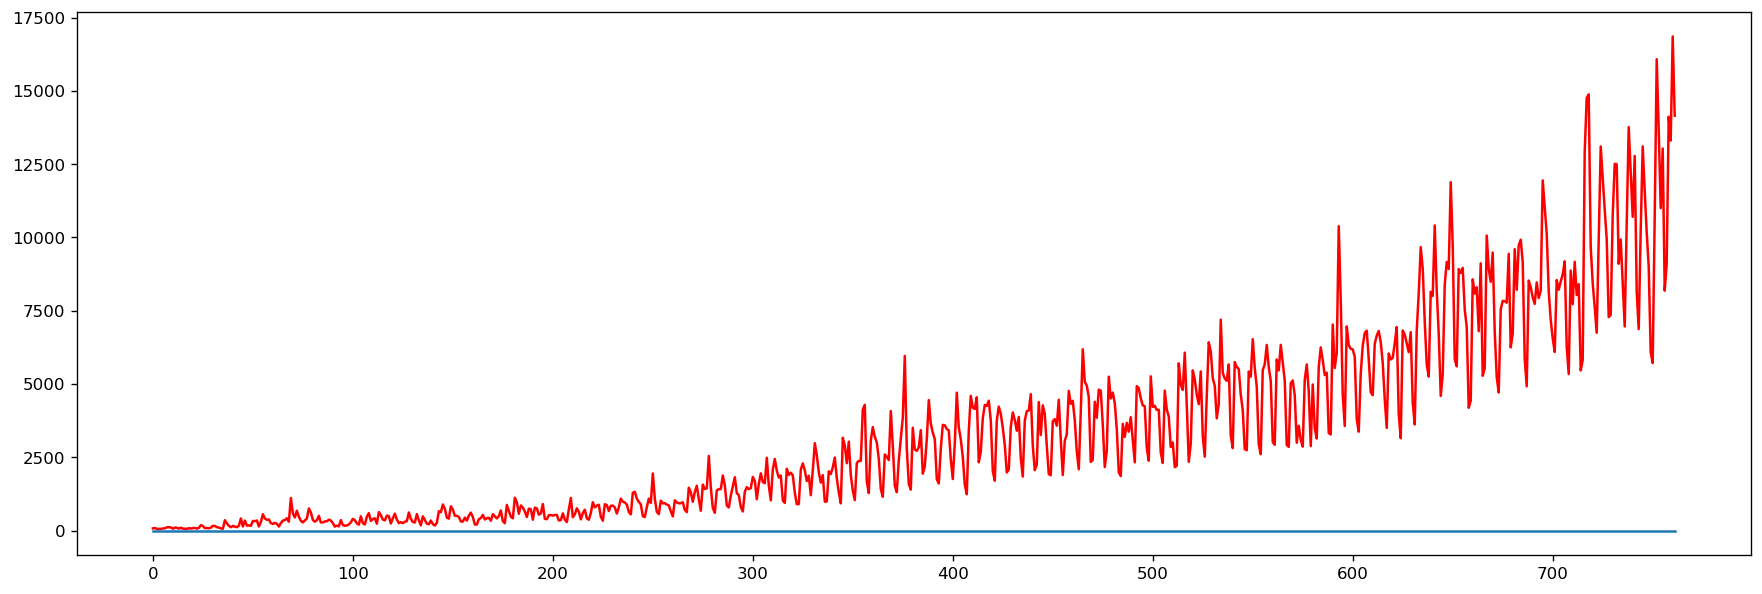

In [16]:
y_old_df = y_old.reset_index(name = 'Count')
y_new_df = y_new.reset_index(name = 'Count')
plt.plot(range(0, len(y_old_df)), train_data['Count'], color='red')
plt.plot(range(0, len(y_old_df)), y_old_df['Count'])

In [17]:
df = pd.read_csv('Train.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%d-%m-%Y %H:%M')
df['date'] = df['Datetime'].dt.date
df = df.groupby(['date'])['Count'].sum().reset_index()
df['date'] = pd.to_datetime(df['date'])
df['month'] = df.date.dt.month
df['day'] = df.date.dt.weekday
df['month_start'] = df.date.apply(lambda x: 1 if x.is_month_start else 0)
df['month_end'] = df.date.apply(lambda x: 1 if x.is_month_end else 0)
df['week_start'] = df.day.apply(lambda x: 1 if x==0 or x ==1 else 0)
df['week_end'] = df.day.apply(lambda x: 1 if x==5 or x==6 else 0)
df['month_day'] = df.date.dt.day
df['predicted'] = y_old_df['Count']
df['diff'] = df.date.apply(lambda x: (x-dateparser.parse('2012-08-25')).days)
df.head()

,date,Count,month,day,month_start,month_end,week_start,week_end,month_day,predicted,diff
0,2012-08-25,76,8,5,0,0,0,1,25,0.0,0
1,2012-08-26,88,8,6,0,0,0,1,26,0.0,1
2,2012-08-27,62,8,0,0,0,1,0,27,0.0,2
3,2012-08-28,58,8,1,0,0,1,0,28,0.0,3
4,2012-08-29,60,8,2,0,0,0,0,29,0.0,4


In [18]:
dfh = df.groupby(['date'])['Count'].sum().reset_index()
dfh.sort_values(['Count'], ascending = [False]).head()

,date,Count
760,2014-09-24,16856
752,2014-09-16,16080
718,2014-08-13,14878
717,2014-08-12,14762
761,2014-09-25,14152


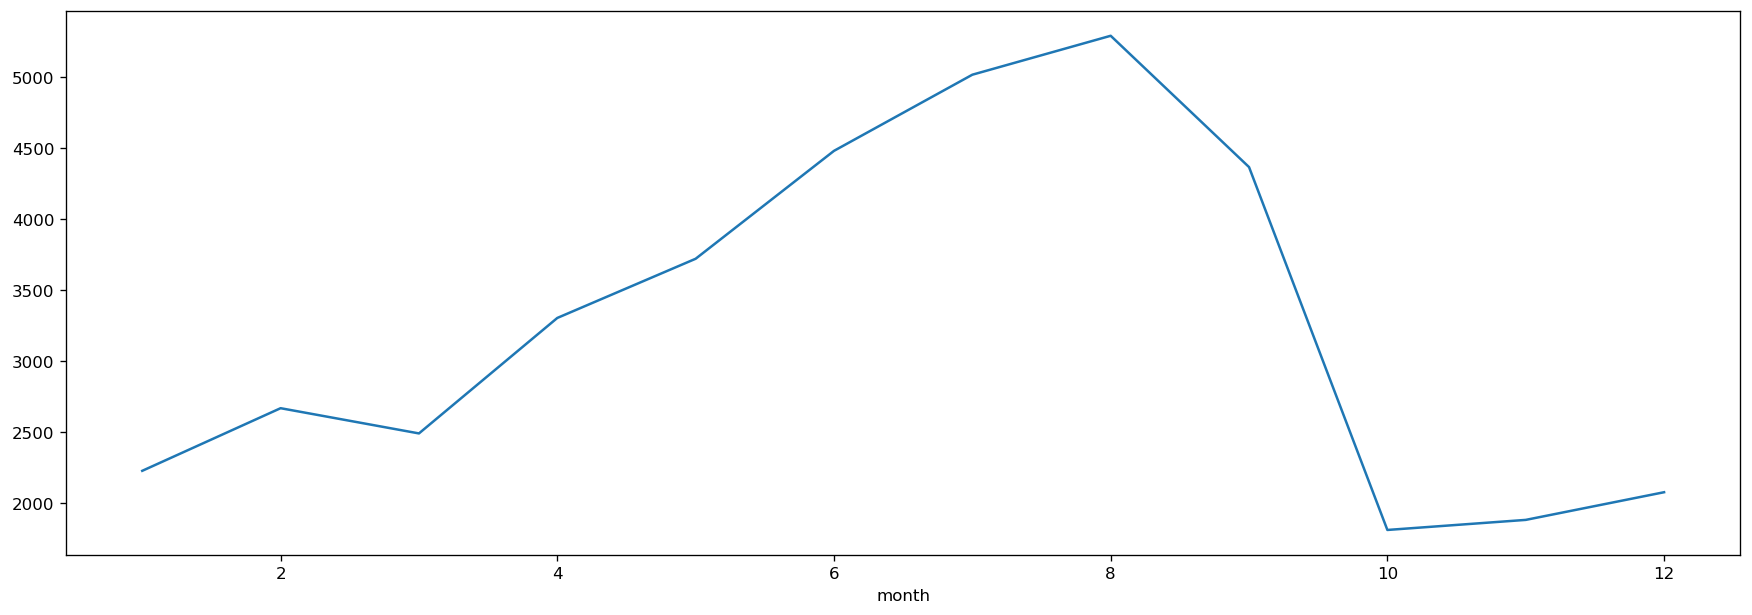

In [19]:
df.groupby(['month'])['Count'].mean().plot()

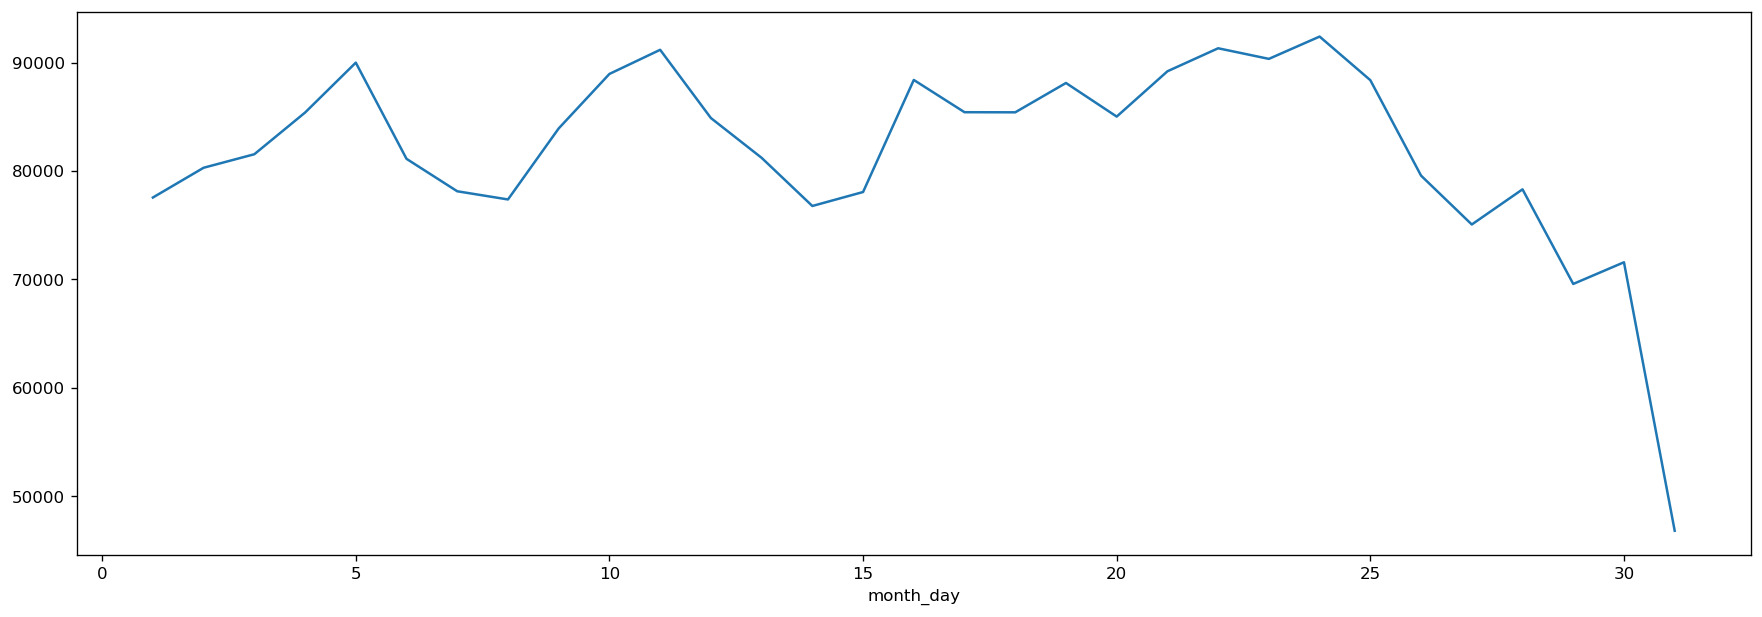

In [20]:
df.groupby(['month_day'])['Count'].sum().plot()

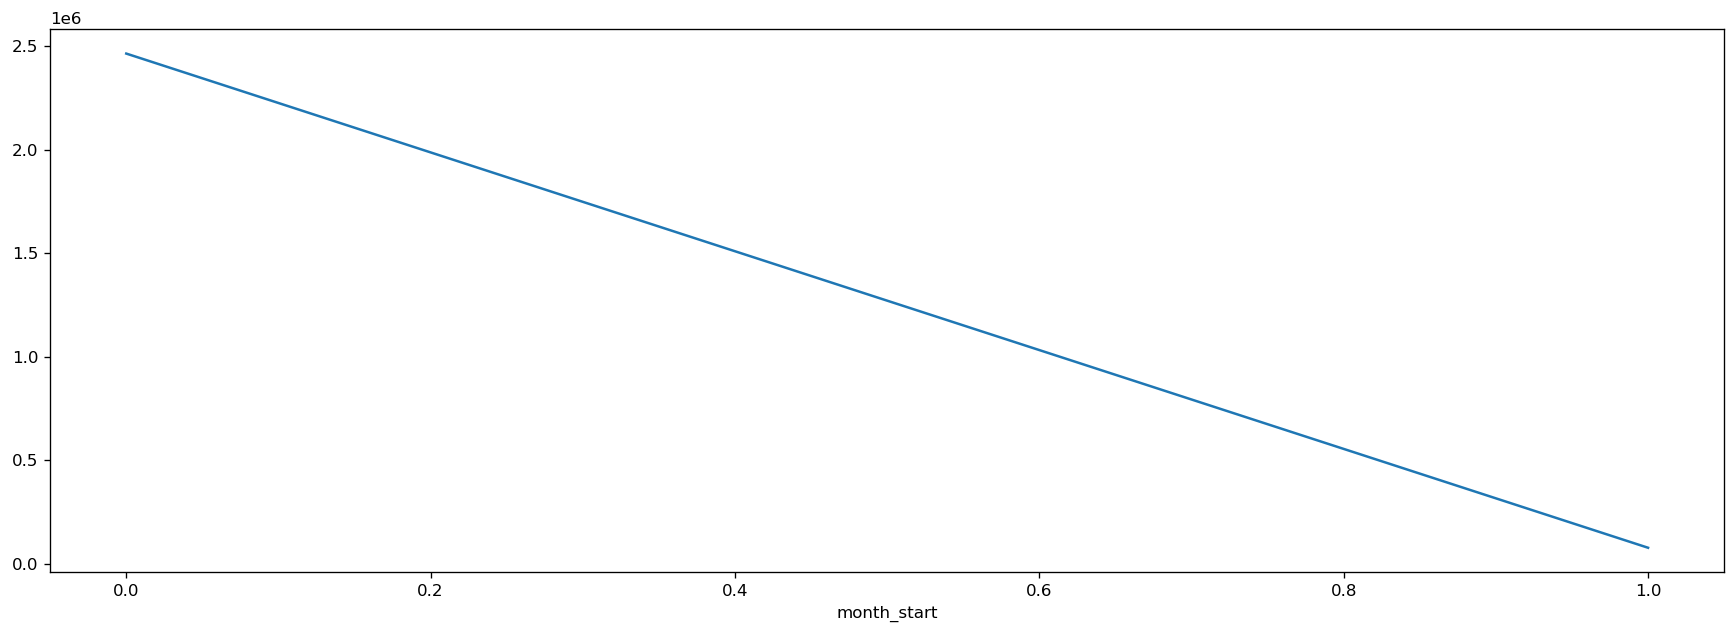

In [21]:
df.groupby(['month_start'])['Count'].sum().plot()

In [22]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast-actual)/np.abs(actual))
    me = np.mean(forecast-actual)
    mae = np.mean(np.abs(forecast-actual))
    mpe = np.mean((forecast-actual)/actual)
    rmse = np.mean((forecast-actual)**2)**0.5
    corr = np.corrcoef(forecast, actual)[0, 1]
    mins = np.amin(np.hstack([forecast[:, None],
                             actual[:, None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:, None],
                             actual[:, None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)
    acf1 = 0
    return({ 'mape': mape, 'me': me, 'mae': mae,
             'mpe' : mpe, 'rmse': rmse, 'acf1': acf1,
             'corr': corr, 'minmax': minmax})

In [23]:
new_df = df.drop(['date'], axis=1)
new_df

,Count,month,day,month_start,month_end,week_start,week_end,month_day,predicted,diff
0,76,8,5,0,0,0,1,25,0.0,0
1,88,8,6,0,0,0,1,26,0.0,1
2,62,8,0,0,0,1,0,27,0.0,2
3,58,8,1,0,0,1,0,28,0.0,3
4,60,8,2,0,0,0,0,29,0.0,4
...,...,...,...,...,...,...,...,...,...,...
757,9102,9,6,0,0,0,1,21,0.0,757
758,14116,9,0,0,0,1,0,22,0.0,758
759,13304,9,1,0,0,1,0,23,0.0,759
760,16856,9,2,0,0,0,0,24,0.0,760


In [24]:
new_df.shape

(762, 10)

In [42]:
test_df = pd.read_csv('Test.csv')
test_df['Datetime'] = pd.to_datetime(test_df['Datetime'], format = '%d-%m-%Y %H:%M')
test_df['date'] = test_df['Datetime'].dt.date
test_df = test_df.groupby(['date']).sum().reset_index()
test_df['date'] = pd.to_datetime(test_df['date'])
test_df['month'] = test_df['date'].dt.month
test_df['day'] = test_df['date'].dt.weekday
test_df['month_start'] = test_df['date'].apply(lambda x: 1 if x.is_month_start else 0)
test_df['month_end'] = test_df['date'].apply(lambda x: 1 if x.is_month_end else 0)
test_df['week_start'] = test_df['day'].apply(lambda x: 1 if x==0 or x==1 else 0)
test_df['week_end'] = test_df['day'].apply(lambda x: 1 if x==5 or x==6 else 0)
test_df['month_day'] = test_df['date'].dt.day
test_df['predicted'] = y_new_df['Count']
test_df['diff'] = test_df['date'].apply(lambda x: (x-dateparser.parse('2012-08-25')).days)
test_df.head()

,date,ID,month,day,month_start,month_end,week_start,week_end,month_day,predicted,diff
0,2014-09-26,439188,9,4,0,0,0,0,26,12400.894564,762
1,2014-09-27,439764,9,5,0,0,0,1,27,9273.649339,763
2,2014-09-28,440340,9,6,0,0,0,1,28,8923.271036,764
3,2014-09-29,440916,9,0,0,0,1,0,29,13128.066046,765
4,2014-09-30,441492,9,1,0,1,1,0,30,14510.342128,766


In [48]:
X_train = new_df[:]
y_train = X_train['Count']
dropcols = ['Count']
X_train.drop(dropcols, axis=1, inplace=True)

X_test = new_df[700:]
y_test = X_test['Count']
X_test.drop(dropcols, axis=1, inplace=True)

testing_df = test_df.drop(['ID', 'date'], axis=1)
testing_df

/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,month,day,month_start,month_end,week_start,week_end,month_day,predicted,diff
0,9,4,0,0,0,0,26,12400.894564,762
1,9,5,0,0,0,1,27,9273.649339,763
2,9,6,0,0,0,1,28,8923.271036,764
3,9,0,0,0,1,0,29,13128.066046,765
4,9,1,0,1,1,0,30,14510.342128,766
...,...,...,...,...,...,...,...,...,...
208,4,2,0,0,0,0,22,27403.481764,970
209,4,3,0,0,0,0,23,25153.604959,971
210,4,4,0,0,0,0,24,25021.952472,972
211,4,5,0,0,0,1,25,21169.160130,973


In [50]:
linear = linear_model.LinearRegression()
linear.fit(X_train, y_train)

linear1 = linear_model.LinearRegression()
linear1.fit(X_train, np.log(y_train))

rtp = linear.predict(X_test)
rtp1 = np.exp(linear1.predict(X_test))

new_rtp = (rtp+rtp1)/2

print(forecast_accuracy(np.array(rtp), np.array(y_test)))
print(forecast_accuracy(np.array(rtp1), np.array(y_test)))

for c, cc in enumerate(linear.coef_):
    print(X_train.columns[c])
    print(cc)

{'mape': 0.18331631191165407, 'me': -1815.6908515838882, 'mae': 2112.4590545368796, 'mpe': -0.13325559035699916, 'rmse': 2887.8505348863973, 'acf1': 0, 'corr': 0.8112227612761449, 'minmax': 0.17909040038793744}
{'mape': 0.40662833727861186, 'me': 3698.897559251655, 'mae': 3735.272105679394, 'mpe': 0.4041811016919465, 'rmse': 4113.853223617809, 'acf1': 0, 'corr': 0.8197194624855455, 'minmax': 0.2736674647612961}
month
106.58183756868922
day
-139.934054420642
month_start
-107.74917327239275
month_end
-166.66832842220361
week_start
-183.1539964930536
week_end
-1087.2352312517646
month_day
-2.406013150462505
predicted
0.0
diff
13.254186636863936


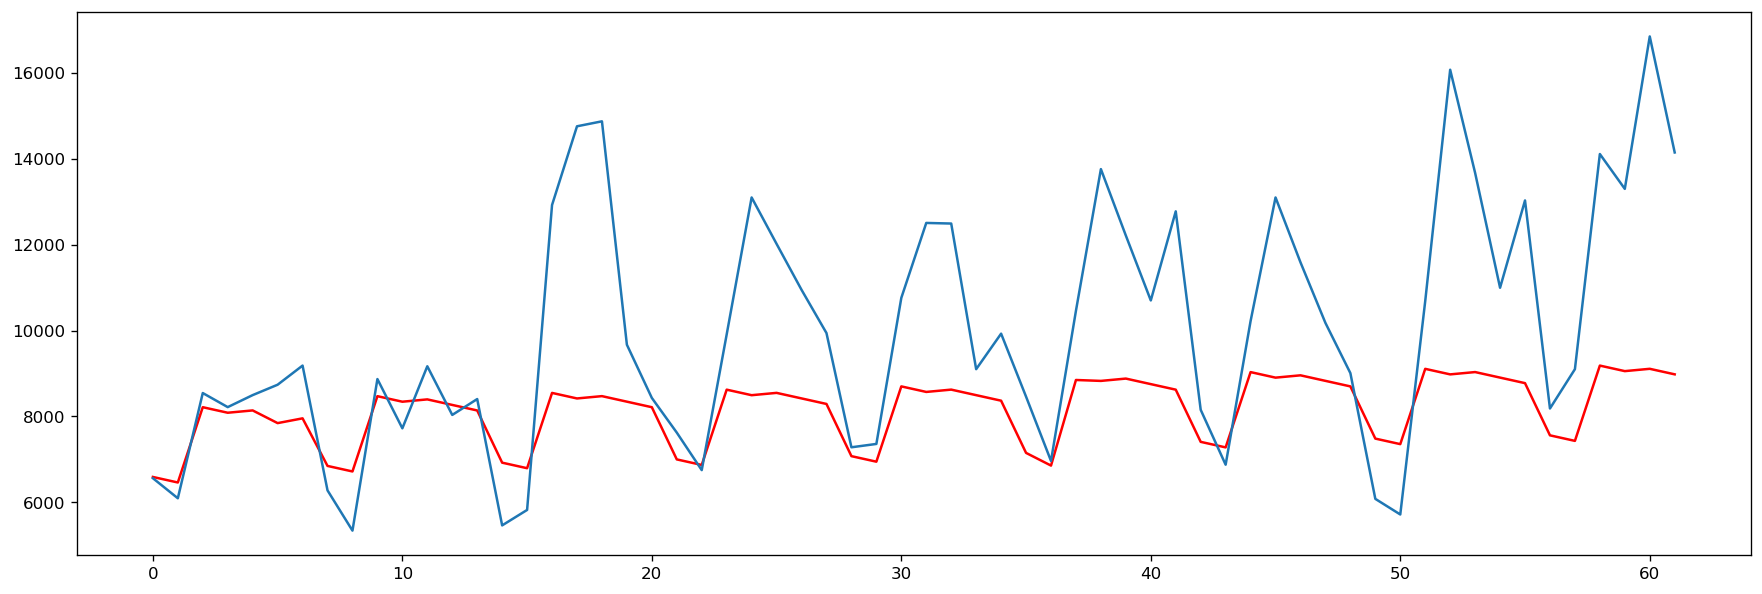

In [51]:
plt.plot(range(0, len(rtp)), rtp, color='red')
plt.plot(range(0, len(rtp)), y_test)

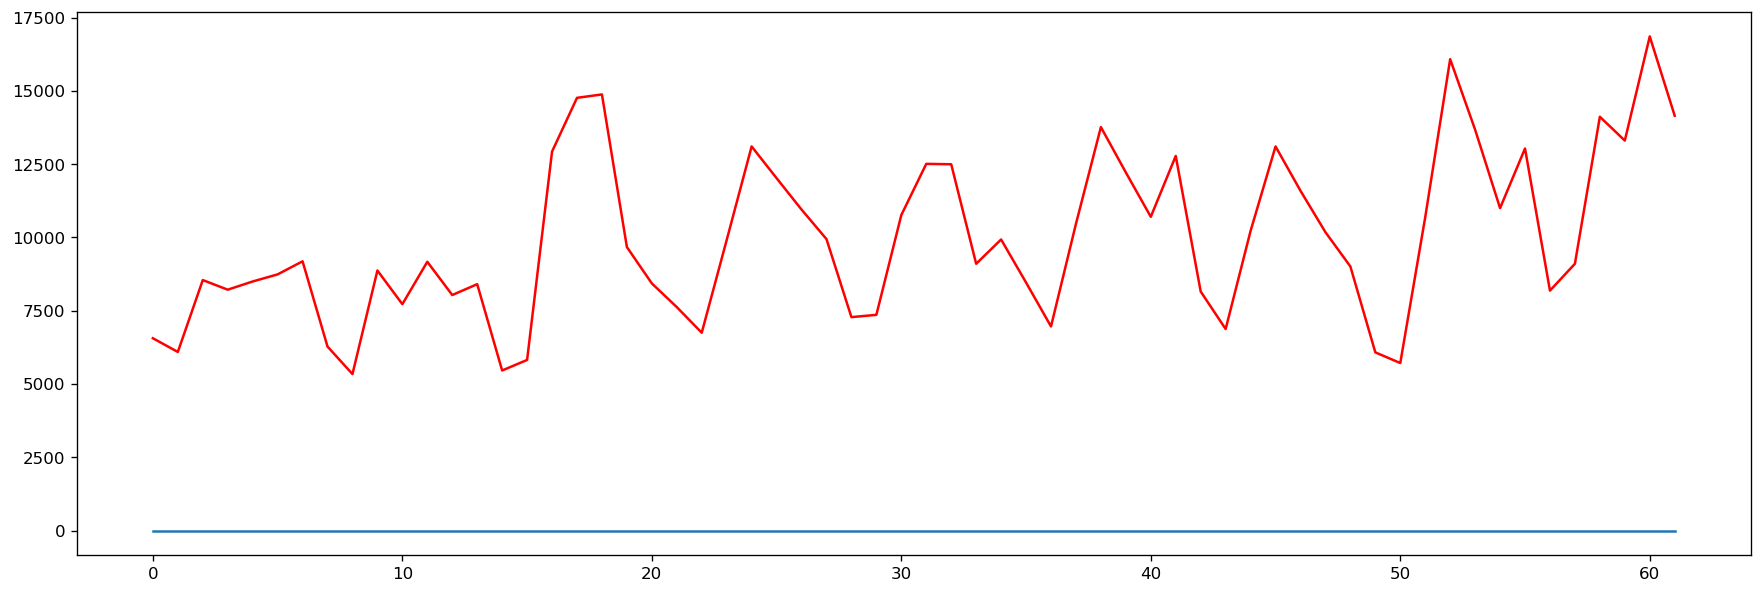

In [58]:
plt.plot(range(0, len(y_old_df[700:])), train_data[700:]['Count'], color='red')
plt.plot(range(0, len(y_old_df[700:])), y_old_df[700:]['Count'])

In [60]:
rf = RandomForestRegressor(random_state = 42)
random_grid = {'bootstrap': [True, False],
              'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10, 15],
              'n_estimators': [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,n_iter=100, 
                               cv=5, verbose=1, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.0min finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10, 15],
                                        'n_estimators': [100, 200, 400, 600,
                                                         800, 1000, 1200, 1400,
                                                         1600, 1800, 2000]},
                   random_state=42, verbose=1)

In [61]:
rf_model = RandomForestRegressor(**rf_random.best_params_)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=60, min_samples_leaf=4, min_samples_split=5)

In [62]:
rtp = rf_model.predict(X_test)
print(forecast_accuracy(np.array(rtp), np.array(y_test)))

{'mape': 0.0810691859348737, 'me': -9.450998929817645, 'mae': 815.0218687912478, 'mpe': 0.015294463465200607, 'rmse': 1055.5837000986294, 'acf1': 0, 'corr': 0.9333323316431354, 'minmax': 0.07598623567255525}


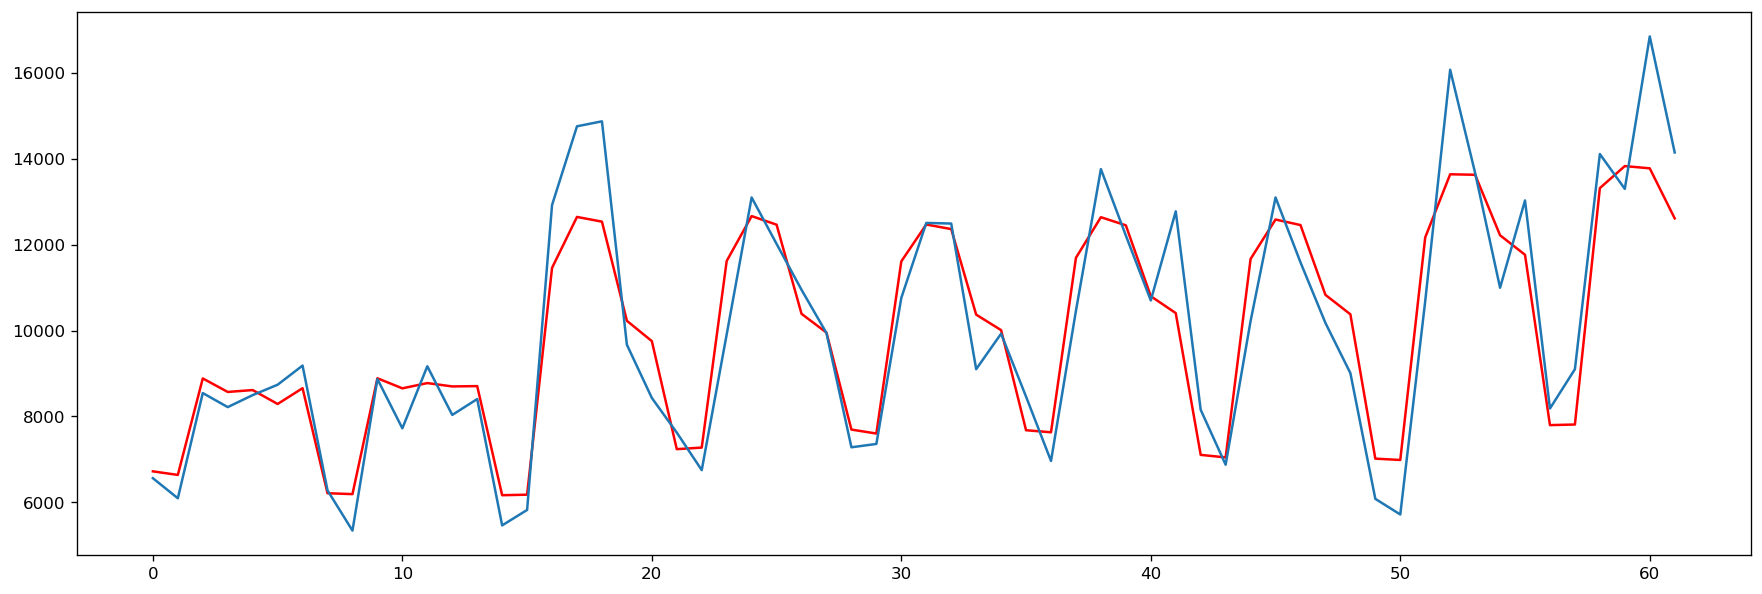

In [63]:
plt.plot(range(0, len(rtp)), rtp, color='red')
plt.plot(range(0, len(rtp)), y_test)

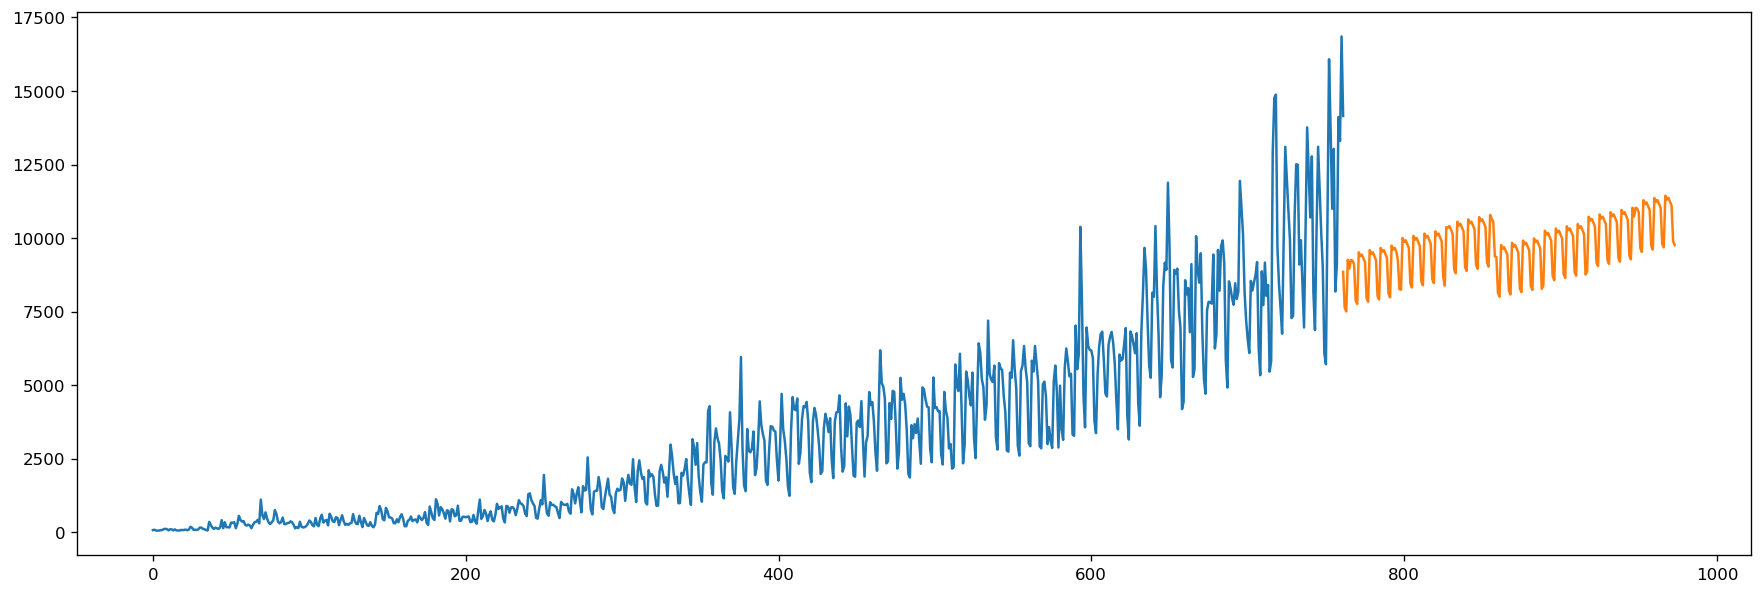

In [64]:
linear_pred = linear.predict(testing_df)

plt.plot(df.index, df.Count)
plt.plot(testing_df.index+761, linear_pred)

In [68]:
linear_pred.sum()

2077410.2207563492

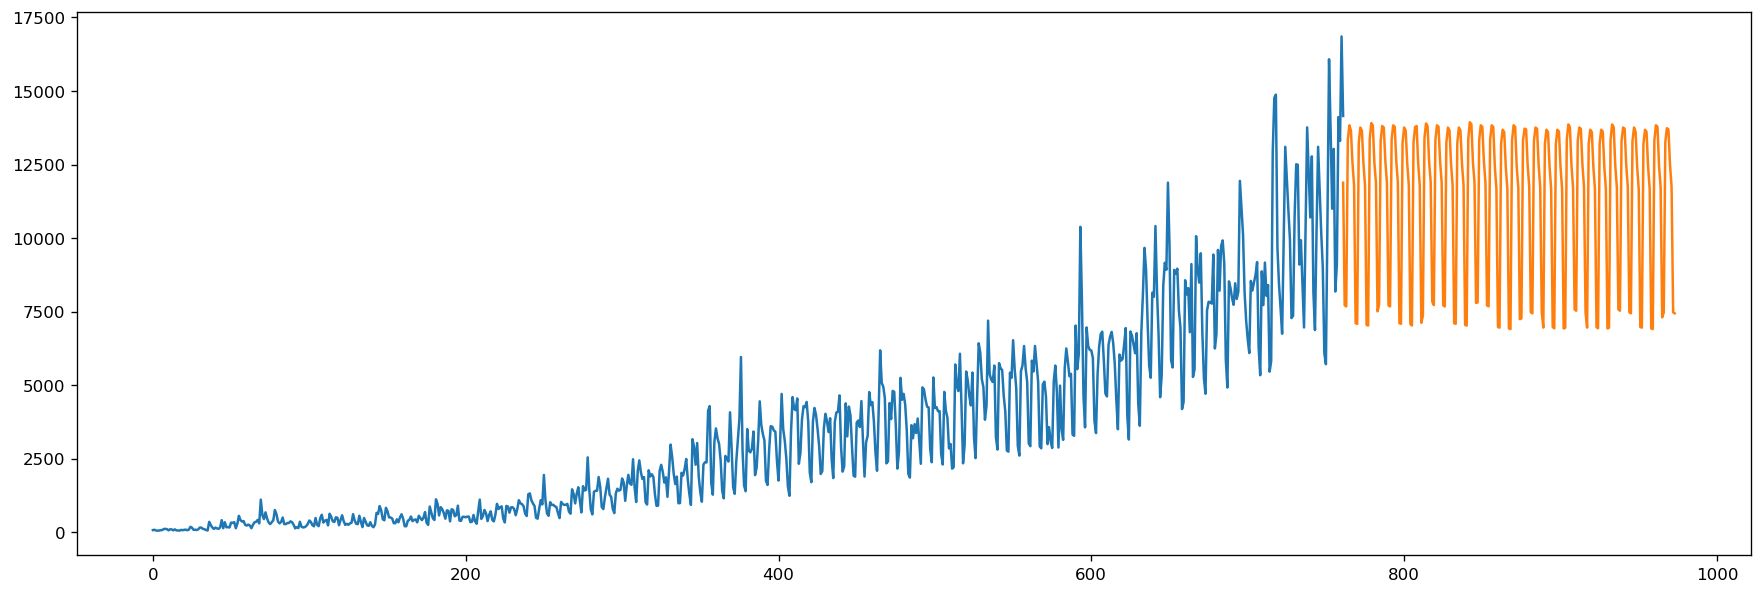

In [66]:
rf_test_pred = rf_model.predict(testing_df)
plt.plot(df.index, df.Count)
plt.plot(testing_df.index+761, rf_test_pred)

In [67]:
rf_test_pred.sum()

2415132.542141079

In [69]:
ensemble_preds = (y_new + f_preds + rf_test_pred)/3
ensemble_preds

2014-09-26    12549.472571
2014-09-27     8693.513870
2014-09-28     8472.687967
2014-09-29    13904.200311
2014-09-30    14579.693146
                  ...     
2015-04-22    23351.930799
2015-04-23    22048.365235
2015-04-24    21636.478734
2015-04-25    15759.203483
2015-04-26    15244.340075
Freq: D, Length: 213, dtype: float64

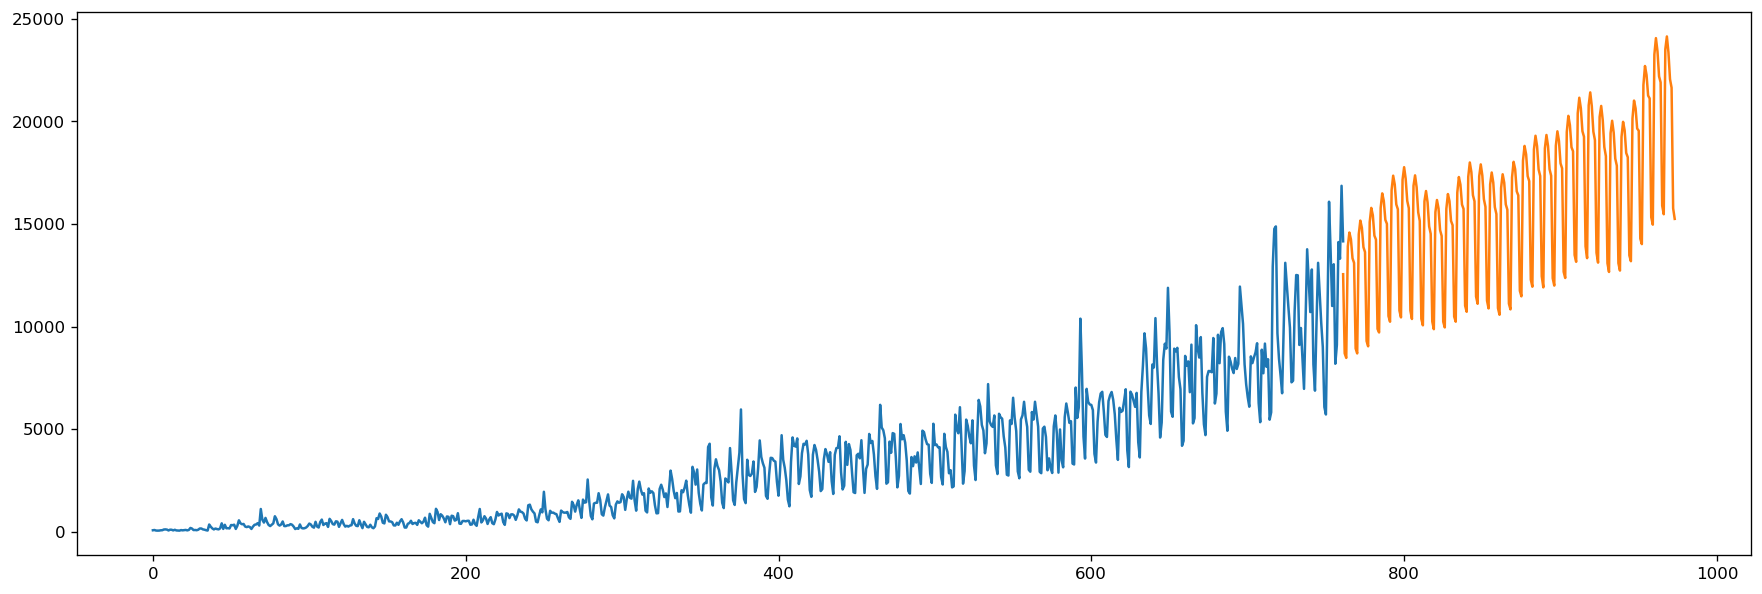

In [70]:
plt.plot(X_train.index, y_train)
plt.plot(testing_df.index+761, ensemble_preds)

In [72]:
er = []

listm = [0.044286588, 
         0.035343014, 
         0.029911076, 
         0.024714453, 
         0.02080223, 
         0.018621427, 
         0.020023091, 
         0.023221497, 
         0.026741002, 
         0.034555218,
         0.049047207, 
         0.05437526, 
         0.054951351, 
         0.048600186, 
         0.051965438, 
         0.051309072, 
         0.049999488, 
         0.051164262, 
         0.052423477, 
         0.055626605, 
         0.053455246, 
         0.049894816, 
         0.050075828, 
         0.048892166]

for p in range(len(ensemble_preds)):
    for l in range(len(listm)):
        er.append(ensemble_preds[p]*listm[l])

d = {'Count': er}
predf = pd.DataFrame(data=d)
submissiom_df = pd.DataFrame({
    'ID': pd.Series([x+18288 for x in range(5112)]),
    "Count": pd.Series(predf['Count'])
})
submission_df.to_csv('submission.csv', index=False)

In [74]:
sub = pd.read_csv('submission.csv')
sub

,ID,Count
0,18288,591.782804
1,18289,472.273636
2,18290,399.688963
3,18291,330.248704
4,18292,277.971335
...,...,...
5107,23395,978.100973
5108,23396,939.921250
5109,23397,877.317033
5110,23398,880.499827
